# Energy Stock Price Movements 

Using information from [EIA](https://www.eia.gov/) we will determine if monitoring changes in cash market power prices have a strong relationship with the price of energy sector stocks.  

This can become the foundation for a variety of use cases within the functions of an exchange, clearing house, trading firm, or compliance:

In [48]:
import pandas as pd
from google.cloud import bigquery
from pandas.io import gbq
import numpy as np
import matplotlib.pyplot as plt

## Query Trade Data on NRG Stream   [$NRG:NDAQ](https://www.nasdaq.com/market-activity/stocks/nrg)

Ask BigQuery for T&S Data aggregated on a monthly trade weighted price.  Data is located on AWS.  BQ automatically knows where to look based upon my query and returns it without concern for where it came.

Source: BigQuery OMNI -- **Data on AWS!**  `fsi-select-demo.bq_omni_staging_s3.TRADES_WITH_ISSUER`

Destination: Python Pandas Dataframe (tradesDF)


In [50]:
query = """
    SELECT timestamp_trunc(timestamp, month) as date, 
    symbol, 
    sum(trade_size) as total_volume, 
    sum(trade_price * trade_size)/ sum(trade_size) as average_trade_price 
    FROM `fsi-select-demo.bq_omni_staging_s3.TRADES_WITH_ISSUER` 
    WHERE trade_size <> 0
    AND date(timestamp) >= '2013-01-01'
    AND symbol='NRG'
    group by timestamp_trunc(timestamp, month), symbol;
    """
tradesDF = gbq.read_gbq(query, project_id='fsi-select-demo', index_col='date')
tradesDF.head()

,symbol,total_volume,average_trade_price
date,,,
2017-12-01 00:00:00+00:00,NRG,685063536,27.806190
2017-11-01 00:00:00+00:00,NRG,812759310,28.074196
2013-06-01 00:00:00+00:00,NRG,472158018,26.267888
2016-12-01 00:00:00+00:00,NRG,892614360,12.258152
2018-04-01 00:00:00+00:00,NRG,598706694,30.726829


## Trade Price History Visualizations

- Do I have the data I need?
- Should I normalize it (e.g. log return)
- Should I smooth it via resampling?  

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

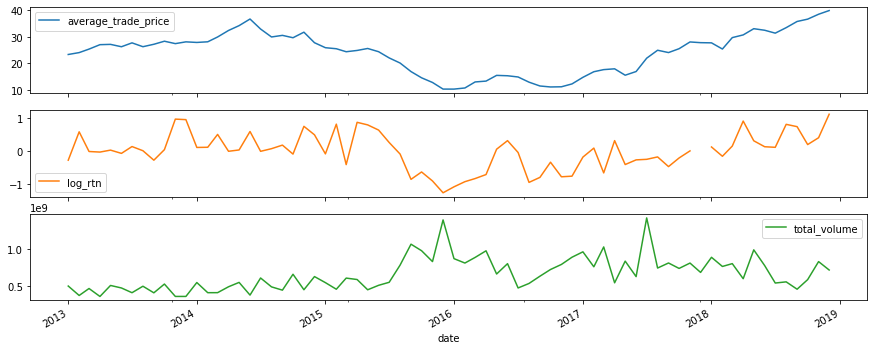

In [51]:
#create column simple return
tradesDF['simple_rtn'] = tradesDF.average_trade_price.pct_change()
#create column logrithmic returns
tradesDF['log_rtn'] = np.log(tradesDF.average_trade_price/tradesDF.average_trade_price.shift(1))
#plot
tradesDF[['average_trade_price','log_rtn','total_volume']].plot(subplots=True, figsize=(15,6))

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

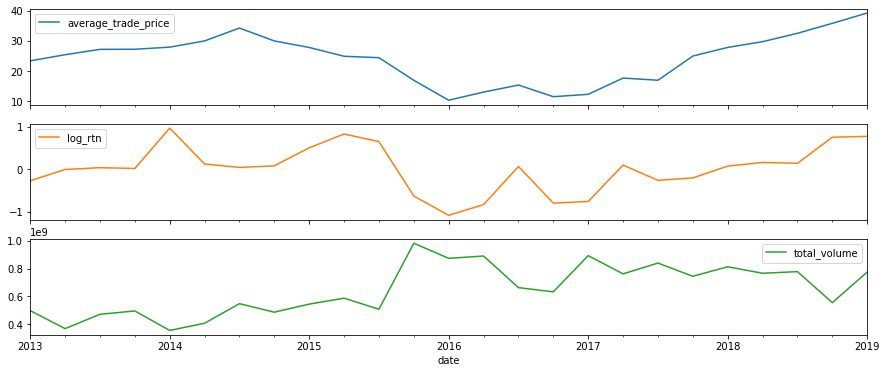

In [52]:
#Resample Plots (3months)
tradesDF[['average_trade_price','log_rtn','total_volume']].resample("3m").median().plot(subplots=True, figsize=(15,6))

## Understand Retail Power Pricing in Texas

Leveraging my prior work to load US EIA Data -- US Energy Information Association--, Ask BigQuery for Power Price data.  Data is located on Google Cloud.  BQ automatically knows where to look based upon my query and returns it without concern for where it came.

Source: BigQuery OMNI GCP Side.  `fsi-select-demo.us_eia.electricity_retail_pricing_type` 

Destination: Python Pandas Dataframe (powerpricingDF)

In [53]:
client = bigquery.Client()#location="US")
print("Client creating using default project: {}".format(client.project))
query = """
    SELECT date, state, commercial, industrial, residential 
    FROM `fsi-select-demo.us_eia.electricity_retail_pricing_type` 
    WHERE state = 'Texas'
    AND date >= '2013-01-01' -- Natural Date Parsing!
    AND date <= %s""" % "'"+tradesDF.index.max().date().strftime('%Y-%m-%d')+"'"  #Pass in max from trades infromation.
query_job = client.query(
    query,
    # Location must match that of the dataset(s) referenced in the query.
    location="US",
)  # API request - starts the query
powerpricingDF = query_job.to_dataframe()

powerpricingDF.set_index('date', inplace=True)
powerpricingDF.head()



Client creating using default project: fsi-select-demo


,state,commercial,industrial,residential
date,,,,
2018-12-01 00:00:00+00:00,Texas,7.74,4.97,11.00
2016-05-01 00:00:00+00:00,Texas,8.26,5.21,11.10
2018-07-01 00:00:00+00:00,Texas,8.08,6.05,11.09
2013-04-01 00:00:00+00:00,Texas,8.06,5.65,11.43
2015-09-01 00:00:00+00:00,Texas,8.11,5.53,11.51


## Price History Visualizations

- Do I have the data I need?
- Should I normalize it?
- Should I smooth it via resampling?  
- What are other statistical facts like correlation?

array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

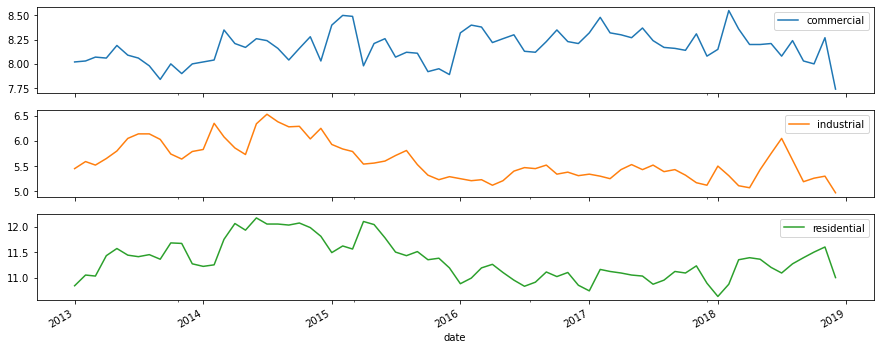

In [54]:
powerpricingDF.plot(subplots=True, figsize=(15,6))

In [55]:
powerpricingDF.corr()

,commercial,industrial,residential
commercial,1.000000,-0.117991,-0.087944
industrial,-0.117991,1.000000,0.612532
residential,-0.087944,0.612532,1.000000


# Join Data Sets

Are there connections between the retail power prices in Texas and the overall performance / price of NRG?



array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>],
      dtype=object)

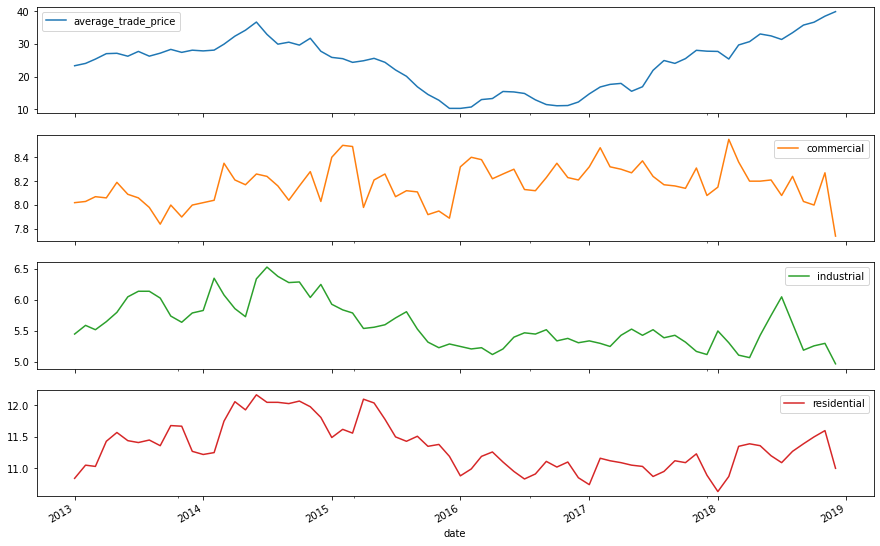

In [56]:
joinedDF = pd.merge(tradesDF[['symbol','average_trade_price']], powerpricingDF, left_index=True, right_index=True)
joinedDF.plot(subplots=True, figsize=(15,10))

## Trade Price and Cash Market Price Correlations

Yes; look at the industrial and residential prices versus the stock price. Residential has a 0.50 R<sup>2</sup>.

In [57]:
# Correlation (All) 
joinedDF.corr()


,average_trade_price,commercial,industrial,residential
average_trade_price,1.000000,-0.226841,0.396888,0.503035
commercial,-0.226841,1.000000,-0.117991,-0.087944
industrial,0.396888,-0.117991,1.000000,0.612532
residential,0.503035,-0.087944,0.612532,1.000000


# Residential Power Prices to NRG Monthly Stock Prices Rolling Periods

Correlations from 2013 to present show a strong relationship. How does that look over rolling periods.  This will become the foundation for a larger strategy on risk managment, reporting, and monitoring various price movements in NRG. I will need to source a realtime price feed from [ERCOT](http://www.ercot.com/mktinfo/rtm)

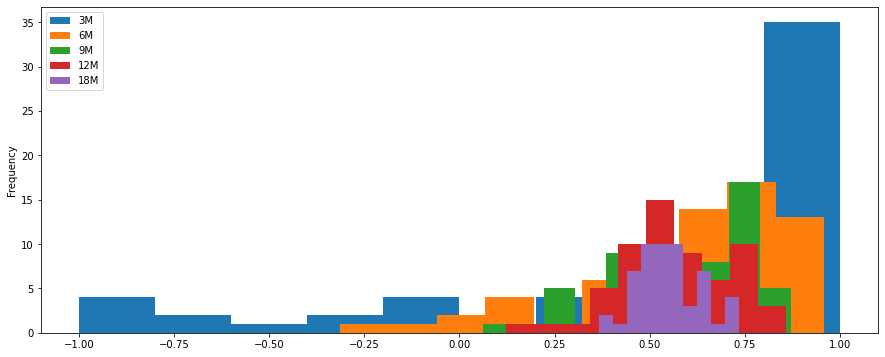

In [58]:
#Rolling Correlation 3, 6, 9, 12 month
fig, ax = plt.subplots()

joinedDF['average_trade_price'].rolling(3).corr(joinedDF['residential']).plot(kind='hist', figsize=(15,6), legend=True)
joinedDF['average_trade_price'].rolling(6).corr(joinedDF['residential']).plot(kind='hist', figsize=(15,6), legend=True)
joinedDF['average_trade_price'].rolling(9).corr(joinedDF['residential']).plot(kind='hist', figsize=(15,6), legend=True)
joinedDF['average_trade_price'].rolling(12).corr(joinedDF['residential']).plot(kind='hist', figsize=(15,6), legend=True)
joinedDF['average_trade_price'].rolling(18).corr(joinedDF['residential']).plot(kind='hist', figsize=(15,6), legend=True)

ax.legend(["3M", "6M",'9M','12M','18M'])
